# Funciones Auxiliares

In [ ]:
library(MASS)
library(rpart)
library(class)
install.packages("randomForest")
library(randomForest)
install.packages("kernlab")
library(kernlab)
library(readr)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
centroGauss <- function(d, v) {
  return(rep(v, d))
}

covMatrix <- function(d, C) {
  return(diag((C * sqrt(d))^2, d, d))
}


diagonales <- function(n, d, C) {
  n0 <- floor(n / 2)
  n1 <- n - n0
  matriz <- covMatrix(d, C)

  valores0 <- MASS::mvrnorm(n0, centroGauss(d, -1), matriz)
  valores1 <- MASS::mvrnorm(n1, centroGauss(d, 1), matriz)

  data <- rbind(cbind(Target = 0, valores0), cbind(Target = 1, valores1))

  colnames(data) <- c('Target', paste0('d', 1:d))

  data <- as.data.frame(data)
  data$Target <- as.factor(data$Target)

  return(as.data.frame(data))
}

In [ ]:
noisyDiags <- function() {
  df <- diagonales(100, 10, 2)
  set.seed(123)

  ruido <- matrix(runif(100 * 90, min = -20, max = 20), nrow = 100, ncol = 90)

  ruido_df <- as.data.frame(ruido)

  colnames(ruido_df) <- paste0("Ruido", 1:90)

  df_extendido <- cbind(df, ruido_df)

  return(df_extendido)
}

In [ ]:
porcentajeAciertos <- function(prediction) {
  prediction <- prediction[1:10]

  en_rango <- prediction >= 1 & prediction <= 10

  return(sum(en_rango)/10)
}

In [ ]:
#-------------------------------------------------------------------------------------
# AVISO: codigo de demostracion
# No es optimo, no es la mejor solucion
#
#Funcion general para forward greedy feature selection
#input:
# x,y inputs y targets
# method es una funcion externa que estima el classification error para un dado clasificador con esos datos
# ... parametros extra para el metodo method
#output:
#list.feat <-numero de orden de importancia de las variables, primero la mas relevante

#-------------------------------------------------------------------------------------
forward.ranking <- function(x,y,method,verbosity=0,... )
{

	max.feat<-dim(x)[2]		#total de features
	num.feat<-1				#numero actual de features
	list.feat<-1:max.feat   #lista para guardar los features elegidos, inicializo como llegaron

	#ranking inicial: elijo la variable con menor error de prediccion
	class.error<-double(max.feat)   #inicializo el vector para guardar el error de cada modelo
	#para cada i, creo el dataset con esa variable sola, entreno un modelo y le mido el error, que lo guardo en class.error[i]
	for(i in 1:max.feat){
		x.train<-x[,i,drop=F]
		class.error[i] <- do.call(method, c(list(x.train, y), list(...)) )
	}

	#guardo la variable con minimo error como primera en mi lista de elegidas. Guardo una lista keep.feat con las que me quedan para seguir eligiendo.
	list.feat[1]<-which.min(class.error)
	keep.feat<-sort(class.error,decreasing=FALSE,index=T)$ix[-1]

	if(verbosity>1) cat("\nFirst feature: ",list.feat[1],"\n")

    #loop principal. A cada paso agrego todas las variables disponibles, de a una, le mido el error y me quedo con la de minimo error. Hasta llegar a meter todas.
	while(num.feat<max.feat){
        #class.error guarda el error de cada modelo. Son max.feat-num.feat modelos.
		class.error<-double(max.feat-num.feat)
		#para cada variable que me queda, la agrego a la lista del paso anterior, entreno el modelo y le mido el error.
		for(i in 1:(max.feat-num.feat)){
		    features<-c(list.feat[1:num.feat],keep.feat[i])
			x.train<-x[,features]
			class.error[i] <- do.call(method, c(list(x.train, y), list(...)) )
		}
		if(verbosity>2) cat("\nFeatures:\n",keep.feat,"\nErrors:\n",class.error)
		#me quedo con el modelo de minimo error, guardo ese feature en la lista de las elegidas, lo saco de la lista de las que quedan.
		best.index<-which.min(class.error)
		list.feat[num.feat+1]<-keep.feat[best.index]
		if(verbosity>1) cat("\n---------\nStep ",1+num.feat,"\nFeature ",best.index)

		keep.feat<-keep.feat[-best.index]
		if(verbosity>2) cat("\nNew search list: ",keep.feat)
		num.feat<-num.feat+1 #proximo paso
	}

	if(verbosity>1){
		cat("\n---------\nFinal ranking ",num.feat," features.")
		cat("\nFeatures: ",list.feat,"\n")
	}

 	return(list.feat)

}


#---------------------------------------------------------------------------
#random forest error estimation (OOB) for greedy search
#---------------------------------------------------------------------------
rf.est <- function(x.train,y,equalize.classes=TRUE,tot.trees=500,mtry=0)
{
	if(mtry<1) mtry<-floor(sqrt(dim(x.train)[2]))
	prop.samples<-table(y)
	if(equalize.classes) prop.samples<-rep(min(prop.samples),length(prop.samples))
	return( randomForest(x.train,y,mtry=mtry,ntree=tot.trees,sampsize=prop.samples)$err.rate[tot.trees] )
}

#---------------------------------------------------------------------------
#LDA error estimation (LOO) for greedy search
#---------------------------------------------------------------------------
lda.est <- function(x.train,y)
{
	m.lda <- lda(x.train,y,CV=TRUE)
	return(error.rate( y , m.lda$class))
}
error.rate <- function(dataA, dataB) sum( dataA != dataB ) / length(dataB)

#---------------------------------------------------------------------------
#SVM error estimation (internal CV) for greedy search
#---------------------------------------------------------------------------
svm.est <- function(x.train,y,type="C-svc",kernel="vanilladot",C=1,cross = 4)
{
  invisible(capture.output(model <- ksvm(as.matrix(x.train), as.factor(y), type=type,kernel=kernel,C=C,cross = cross)))
    return ( model@cross )
}


#---------------------------------------------------------------------------
#random forest ranking method for rfe.
#---------------------------------------------------------------------------
imp.rf <- function(x.train,y,equalize.classes=TRUE,tot.trees=500,mtry=0)
{
	if(mtry<1) mtry<-floor(sqrt(dim(x.train)[2]))
	prop.samples<-table(y)
	if(equalize.classes) prop.samples<-rep(min(prop.samples),length(prop.samples))

	m.rf<-randomForest(x.train,y,ntree=tot.trees,mtry=mtry,sampsize=prop.samples,importance=TRUE)
	imp.mat<-importance(m.rf)
	imp.col<-dim(imp.mat)[2]-1
	rank.list<-sort(imp.mat[,imp.col],decreasing=FALSE,index=T)
	return(list(feats=rank.list$ix,imp=rank.list$x))
}


#---------------------------------------------------------------------------
#linear svm ranking method for rfe. Using kernlab. Multiclass
#---------------------------------------------------------------------------
imp.linsvm <- function(x.train,y,C=100)
{
    num.feat<-dim(x.train)[2]
    tot.problems<-nlevels(y)*(nlevels(y)-1)/2

    invisible(capture.output(m.svm <- ksvm(as.matrix(x.train), y, type="C-svc",kernel="vanilladot",C=C)))

    w<-rep(0.0,num.feat)
    for(i in 1:tot.problems) for(feat in 1:num.feat)
        w[feat]<-w[feat]+abs(m.svm@coef[[i]] %*% m.svm@xmatrix[[i]][,feat])
    rank.list<-sort(w,decreasing=FALSE,index=T)
    return(list(feats=rank.list$ix,imp=rank.list$x))
}


#---------------------------------------------------------------------------
#Ejemplo de uso de las funciones de seleccion
#---------------------------------------------------------------------------

#demo: aplicar el wrapper a los datos de iris
data(iris)
FORW.rf <-forward.ranking(iris[,-5],iris[,5],method="rf.est" ,tot.trees=100,equalize.classes=F)
FORW.lda<-forward.ranking(iris[,-5],iris[,5],method="lda.est")


#---------------------------------------------------------------------------
#Codigo con datasets de ejemplo y para el TP2
#---------------------------------------------------------------------------
#hacer una funcion que cree datos, 2 clases (-1 y 1,n puntos de cada una), d dimensiones, de ruido uniforme [-1,1], con la clase al azar

crea.ruido.unif<-function(n=100,d=2){
x<-runif(2*n*d,min=-1)	#genero los datos
dim(x)<-c(2*n,d)
return(cbind(as.data.frame(x),y=factor(rep(c(-1,1),each=n))))	#le agrego la clase
}

In [ ]:
#---------------------------------------------------------------------------
#CREA DATASET datosA
#Dataset artificial con orden de importancia: 8-6-4-2
#---------------------------------------------------------------------------
crearA <- function() {
  d<-10
  n<-1000
  datos<-crea.ruido.unif(n=n,d=d)

  #tomar 50% de los datos al azar, y hacer que la clase sea el signo de la 8 variable
  shuffle<-sample(1:dim(datos)[1])
  sub<-shuffle[1:dim(datos)[1]*0.5]
  datos[sub,d+1]<-sign(datos[sub,8])
  #tomar 20% de los datos al azar (fuera de los anteriores), y hacer que la clase sea el signo de la 6 variable
  sub<-shuffle[(dim(datos)[1]*0.5):(dim(datos)[1]*0.7)]
  datos[sub,d+1]<-sign(datos[sub,6])
  #tomar 10% de los datos al azar, y hacer que la clase sea el signo de la 4 variable
  sub<-shuffle[(dim(datos)[1]*0.7):(dim(datos)[1]*0.8)]
  datos[sub,d+1]<-sign(datos[sub,4])
  #tomar 5% de los datos al azar, y hacer que la clase sea el signo de la 2 variable
  sub<-shuffle[(dim(datos)[1]*0.8):(dim(datos)[1]*0.85)]
  datos[sub,d+1]<-sign(datos[sub,2])
  datos[,d+1]<-factor(datos[,d+1])

  return(datos)
}

In [ ]:
#---------------------------------------------------------------------------
#CREA DATASET datosB
#Dataset artificial con dos variables relevantes (1-2) y dos variables que son importantes pero que no resuelven el problema (3-4)
#---------------------------------------------------------------------------
#generar n=100,d=8
  crearB <- function() {
  d<-8
  n<-1000
  datos<-crea.ruido.unif(n=n,d=d)
  #hacer que la clase sea el xor de las 2 primeras variables (es usando el signo)
  datos[,d+1]<-sign(datos[,1]*datos[,2])
  #hacer que las variables 3 y 4 tengan un 50% de correlacion con la clase
  shuffle<-sample(1:dim(datos)[1])
  sub<-shuffle[1:dim(datos)[1]*0.5]
  datos[sub,3]<-abs(datos[sub,3])*datos[sub,d+1]
  shuffle<-sample(1:dim(datos)[1])
  sub<-shuffle[1:dim(datos)[1]*0.5]
  datos[sub,4]<-abs(datos[sub,4])*datos[sub,d+1]
  datos[,d+1]<-factor(datos[,d+1])

  return(datos)
}

# Ejercicio 1


## Funciones

In [ ]:
greedyBackward <- function(x, y, method, ...)
{
	max.feat<-dim(x)[2]
	num.feat<-dim(x)[2]
	list.feat<-1:num.feat

	class.error<-double(num.feat)

	for(i in 1:max.feat){
		x.train<-x[,list.feat[-i],drop=F]
		class.error[i] <- do.call(method, c(list(x.train, y), list(...)))
	}

	list.feat[max.feat]<-which.min(class.error)
	keep.feat<-sort(class.error,decreasing=FALSE,index=T)$ix[-1]

  num.feat<-num.feat-1

	while(num.feat>1){
		class.error<-double(num.feat)
		for(i in 1:num.feat){
			x.train<-x[,keep.feat[-i],drop=F]
			class.error[i] <- do.call(method, c(list(x.train, y), list(...)))
		}

		best.index<-which.min(class.error)

		list.feat[num.feat]<-keep.feat[best.index]

		keep.feat<-keep.feat[-best.index]
		num.feat<-num.feat-1
	}

  list.feat[1] = keep.feat[1]

 	return(list.feat)
}

In [ ]:
kruskalWallis <- function(x, y)
{
  max.feat<-dim(x)[2]
  class.error <- double(dim(x)[2])

  for (i in 1:max.feat){
    x.train<-x[,i]
    class.error[i] <- kruskal.test(x.train,y)$p.value
  }

  return(order(class.error))
}

In [ ]:
rfe <- function(x, y, method, ...)
{
  max.feat <- dim(x)[2]
  list.feat <- 1:max.feat
  keep.feat <- 1:max.feat

  for (i in 1:max.feat){
    class.error <- do.call(method, c(list(x[, keep.feat, drop=F], y), list(...)))
    least.important <- class.error$feats[1]
    list.feat[max.feat - i + 1] <- keep.feat[least.important]
    keep.feat <- keep.feat[-least.important]
  }

  return (list.feat)
}

## Uso

In [ ]:
data(iris)
cat("\nGreedy Forward: ", forward.ranking(iris[,-5],iris[,5],method="rf.est",tot.trees=100,equalize.classes=F))
cat("\nGreedy Backward: ", greedyBackward(iris[,-5],iris[,5],method="rf.est",tot.trees=100,equalize.classes=F))
cat("\nKruskal Wallis: ", kruskalWallis(iris[,-5],iris[,5]))
cat("\nRFE: ", rfe(iris[,-5],iris[,5],method="imp.rf"))


Greedy Forward:  4 3 1 2
Greedy Backward:  4 3 2 1
Kruskal Wallis:  4 3 1 2
RFE:  3 4 1 2

# Ejercicio 2

## DatosA

In [ ]:
datosA <- crearA()

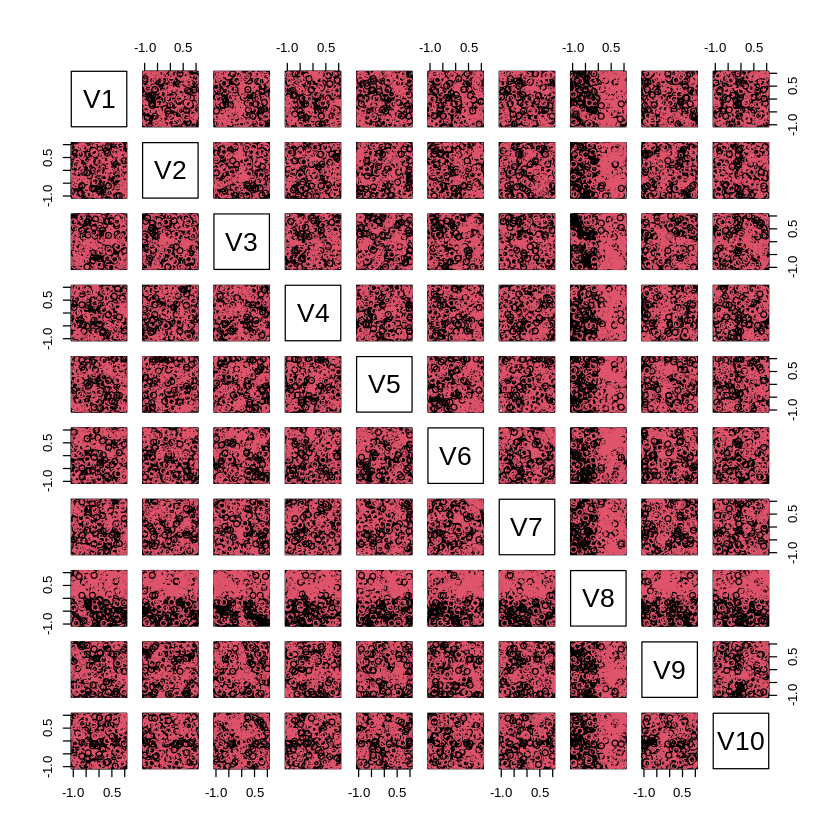

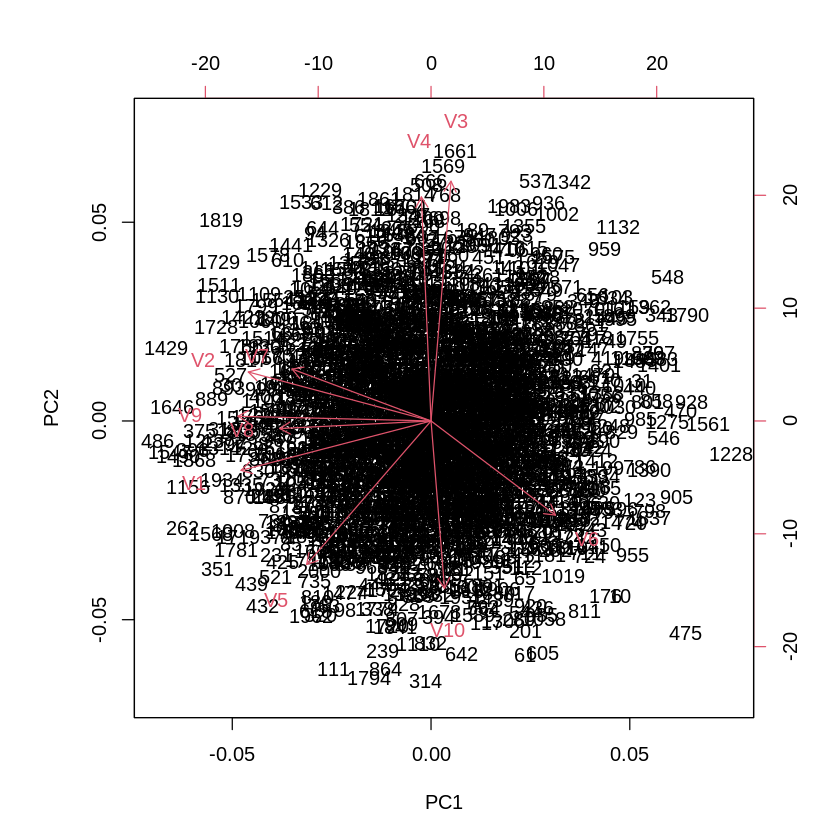

In [ ]:
plot(datosA[,1:10],col=datosA[,11])
datos.pca<-prcomp(datosA[,-11],scale=T)
biplot(datos.pca)

In [ ]:
data<-datosA[, -11]
clases<-datosA[, 11]
cat("Greedy Forward rf.est: ", forward.ranking(data,clases,method="rf.est"))
cat("\nGreedy Forward lda.est: ", forward.ranking(data,clases,method="lda.est"))
cat("\nGreedy Forward svm.est: ", forward.ranking(data,clases,method="svm.est"))
cat("\nGreedy Backward rf.est: ", greedyBackward(data,clases,method="rf.est"))
cat("\nGreedy Backward lda.est: ", greedyBackward(data,clases,method="lda.est"))
cat("\nGreedy Backward svm.est: ", greedyBackward(data,clases,method="svm.est"))
cat("\nKruskal Wallis: ", kruskalWallis(data,clases))
cat("\nRFE imp.rf: ", rfe(data,clases,method="imp.rf"))
cat("\nRFE imp.linsvm: ", rfe(data,clases,method="imp.linsvm"))

Greedy Forward rf.est:  8 6 7 5 10 2 9 3 4 1
Greedy Forward lda.est:  8 9 3 7 1 5 10 2 4 6
Greedy Forward svm.est:  8 3 5 1 10 7 2 9 4 6
Greedy Backward rf.est:  8 3 10 7 9 5 4 2 1 6
Greedy Backward lda.est:  8 9 3 7 1 5 10 2 4 6
Greedy Backward svm.est:  8 3 5 7 10 1 2 4 9 6
Kruskal Wallis:  8 6 4 2 1 9 3 5 10 7
RFE imp.rf:  8 6 4 5 7 3 2 9 10 1
RFE imp.linsvm:  8 6 4 2 9 10 3 1 5 7

Viendo el primer gráfico generado, teniendo en cuenta el código para clasificar las muestras, se puede observar claramente que las clases 8 y 6 son de gran ayuda para determinar la clase de estas. En cuanto a las clases 4 y 2, visualmente no parecen ser de gran ayuda. A pesar de esto, sorprende ver que algunas funciones de ranking las ubicaron entre las variables más importantes, en particular Greedy Backward (en algunas ejecuciones), Kruskal-Wallis (que las clasificó perfectamente) y RFE con ambas funciones de ranking. La búsqueda pseudoaleatoria (RFE) pareció conseguir mejores predicciones que la greedy (Backward y Forward).

En cuanto al biplot de los PCA, no hay nada que pueda remarcar, ya que, al generarse los valores de cada clase con ruido uniforme, al volver a generar los datos, dos clases que parecían estar relacionadas en la iteración anterior dejan de estarlo en la siguiente.

## DatosB

In [ ]:
datosB <- crearB()

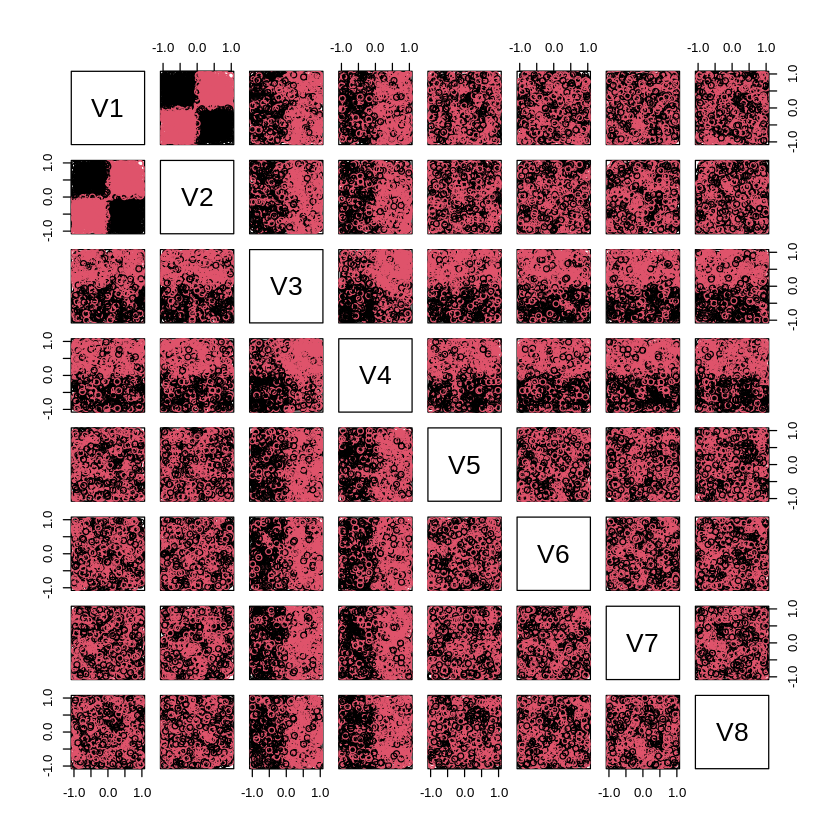

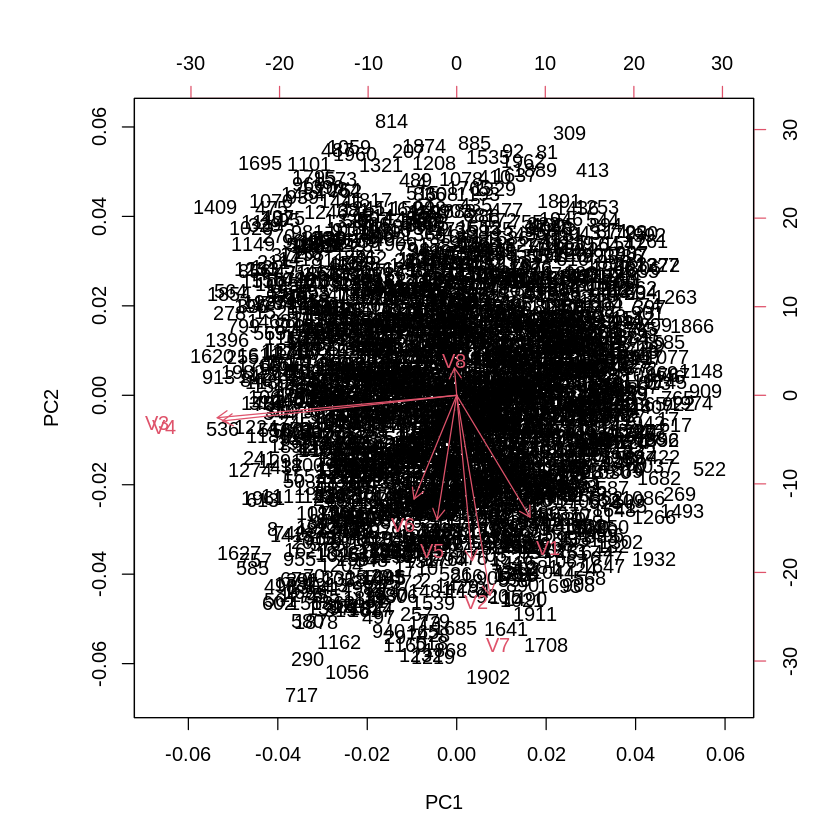

In [ ]:
plot(datosB[,1:8],col=datosB[,9])
datos.pca<-prcomp(datosB[,-9],scale=T)
biplot(datos.pca)

In [ ]:
data<-datosB[, -9]
clases<-datosB[, 9]
cat("Greedy Forward rf.est: ", forward.ranking(data,clases,method="rf.est"))
cat("\nGreedy Forward lda.est: ", forward.ranking(data,clases,method="lda.est"))
cat("\nGreedy Forward svm.est: ", forward.ranking(data,clases,method="svm.est"))
cat("\nGreedy Backward rf.est: ", greedyBackward(data,clases,method="rf.est"))
cat("\nGreedy Backward lda.est: ", greedyBackward(data,clases,method="lda.est"))
cat("\nGreedy Backward svm.est: ", greedyBackward(data,clases,method="svm.est"))
cat("\nKruskal Wallis: ", kruskalWallis(data,clases))
cat("\nRFE imp.rf: ", rfe(data,clases,method="imp.rf"))
cat("\nRFE imp.linsvm: ", rfe(data,clases,method="imp.linsvm"))

Greedy Forward rf.est:  3 4 2 1 5 6 7 8
Greedy Forward lda.est:  3 4 8 2 7 6 1 5
Greedy Forward svm.est:  3 4 8 5 1 7 2 6
Greedy Backward rf.est:  2 1 5 7 8 6 3 4
Greedy Backward lda.est:  3 4 8 6 5 7 1 2
Greedy Backward svm.est:  3 4 8 6 2 1 7 5
Kruskal Wallis:  3 4 1 5 7 8 6 2
RFE imp.rf:  2 1 3 4 8 6 5 7
RFE imp.linsvm:  3 4 1 6 5 8 7 2

Al igual que en el apartado anterior, al observar el primer gráfico, se puede notar una clara diferencia entre las clases cuando se analizan las clases 1 y 2 juntas, así como en todas las combinaciones con las clases 3 y 4. Esto tiene sentido, ya que el código establece que la clase sea el producto del signo de 1 y 2, mientras que a 3 y 4 se les asignó el signo de sus respectivas clases. Nuevamente, dado que las variables de las muestras fueron generadas con ruido uniforme, el gráfico del biplot muestra resultados diferentes en cada iteración en la que se ejecuta.

En cuanto a los resultados de las funciones de ranking, algo notable fue que Kruskal-Wallis dejó de predecir tan perfectamente el ranking de las variables. Esto se debe a que es necesario evaluar las clases 1 y 2 al mismo tiempo para determinar su clara importancia, y al utilizar Kruskal-Wallis, que emplea un sistema de ganancia de información, este método no es eficaz en situaciones que presentan un caso de "XOR". Al igual que en el caso anterior, la búsqueda pseudoaleatoria consiguió mejores resultados que la greedy (especialmente utilizando Random Forest). En general, Random Forest fue el clasificador que obtuvo los mejores resultados, logrando ubicar a las clases 1 y 2 en el top 4 con cada método.

# Ejercicio 3

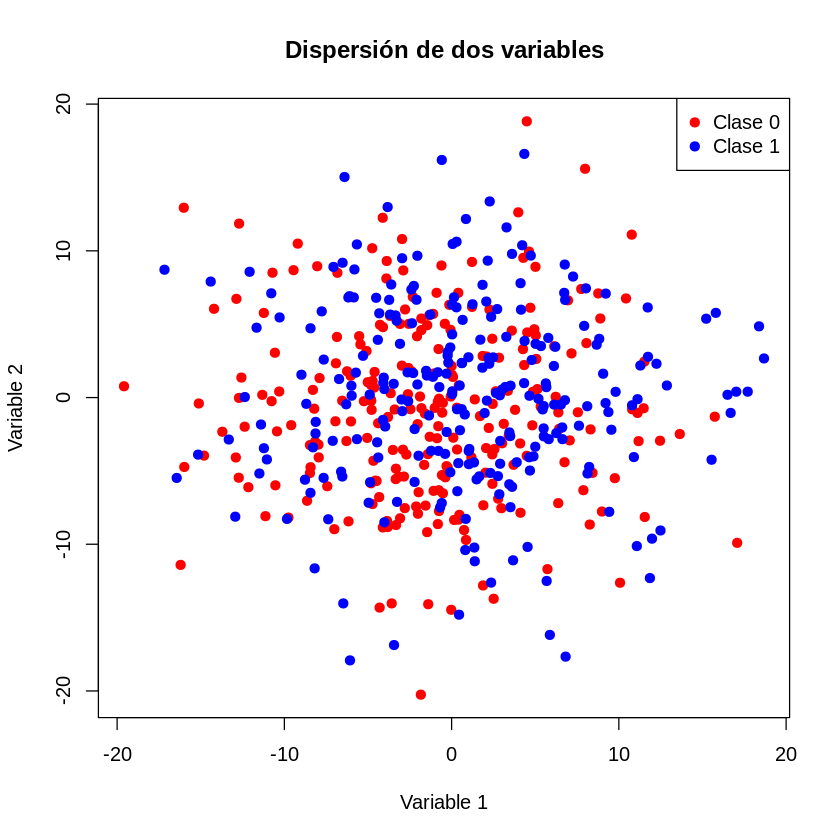

In [ ]:
diag <- diagonales(500, 10, 2)

plot(diag[, 2], diag[, 3],
     col = ifelse(diag$Target == 0, "red", "blue"),
     pch = 19,
     xlab = "Variable 1",
     ylab = "Variable 2",
     main = "Dispersión de dos variables")

legend("topright", legend = c("Clase 0", "Clase 1"),
       col = c("red", "blue"),
       pch = 19)

In [ ]:
iters <- 30
promedios <- list(
  "Greedy Forward rf.est" = 0,
  "Greedy Forward svm.est" = 0,
  "Greedy Backward rf.est" = 0,
  "Greedy Backward svm.est" = 0,
  "Kruskal Wallis" = 0,
  "RFE imp.rf" = 0,
  "RFE imp.linsvm" = 0
)

for (i in 1:iters) {
  df <- noisyDiags()

  data <- df[, -1]
  clases <- df[, 1]

  promedios[["Greedy Forward rf.est"]] <- promedios[["Greedy Forward rf.est"]] + porcentajeAciertos(forward.ranking(data,clases,method="rf.est",tot.trees=100,equalize.classes=F))

  promedios[["Greedy Forward svm.est"]] <- promedios[["Greedy Forward svm.est"]] + porcentajeAciertos(forward.ranking(data,clases,method="svm.est"))

  promedios[["Greedy Backward rf.est"]] <- promedios[["Greedy Backward rf.est"]] + porcentajeAciertos(greedyBackward(data,clases,method="rf.est",tot.trees=100,equalize.classes=F))

  promedios[["Greedy Backward svm.est"]] <- promedios[["Greedy Backward svm.est"]] + porcentajeAciertos(greedyBackward(data,clases,method="svm.est"))

  promedios[["Kruskal Wallis"]] <- promedios[["Kruskal Wallis"]] + porcentajeAciertos(kruskalWallis(data,clases))

  promedios[["RFE imp.rf"]] <- promedios[["RFE imp.rf"]] + porcentajeAciertos(rfe(data,clases,method="imp.rf",tot.trees=100,equalize.classes=F))

  promedios[["RFE imp.linsvm"]] <- promedios[["RFE imp.linsvm"]] + porcentajeAciertos(rfe(data,clases,method="imp.linsvm"))
}

In [ ]:
for (clave in names(promedios)) {
  valor <- promedios[[clave]] / iters

  cat("\n", clave, ": ", valor)
}

Como Colab tardaba tanto en correr y se rompia en el medio de vez en cuando, corri este ejercicio en mi computadora y pegue lo que me devolvio.

Greedy Forward rf.est :  18,66%

Greedy Forward svm.est :  26,33%

Greedy Backward rf.est :  21%

Greedy Backward svm.est :  24,66%

Kruskal Wallis :  43,33%

RFE imp.rf :  33%

RFE imp.linsvm :  31%

Algo a destacar de este ejercicio es que, dada la varianza utilizada para generar las muestras con distribución normal, las muestras no lograron estar muy bien divididas. Generé el gráfico con muchos puntos para que se pueda ver bien.

Teniendo en cuenta la cantidad de variables, al hacer una predicción aleatoria del ranking, se esperaría obtener un 10% de aciertos en promedio en las primeras 10 posiciones.

Sin embargo, aunque una predicción correcta parece tan poco probable, todos los métodos de ranking consiguieron mejores predicciones que la aleatoria, alcanzando hasta un 43% de aciertos con Kruskal-Wallis. Por otra parte, RFE volvió a obtener mejores resultados que las búsquedas greedy.

# Ejercicio 4

Para este ejercicio use un dataset de ["Heart Attack Analysis & Prediction Dataset"](https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset) de Kaggle. Este dataset ya fue limpiado de varias variables (paso de 76 a 13) y se eliminaron ourliers.

1. age - age in years

2. sex - sex (1 = male; 0 = female)

3. cp - chest pain type (1 = typical angina; 2 = atypical angina; 3 = non-anginal pain; 0 = asymptomatic)

4. trtbps - resting blood pressure (in mm Hg on admission to the hospital)

5. chol - serum cholestoral in mg/dl

6. fbs - fasting blood sugar > 120 mg/dl (1 = true; 0 = false)

7. restecg - resting electrocardiographic results (1 = normal; 2 = having ST-T wave abnormality; 0 = hypertrophy)

8. thalachh - maximum heart rate achieved

9. exng - exercise induced angina (1 = yes; 0 = no)

10. oldpeak - ST depression induced by exercise relative to rest

11. slp - the slope of the peak exercise ST segment (2 = upsloping; 1 = flat; 0 = downsloping)

12. caa - number of major vessels (0-3) colored by flourosopy

13. thall - 2 = normal; 1 = fixed defect; 3 = reversable defect

14. num - the predicted attribute - diagnosis of heart disease (angiographic disease status) (Value 0 = < diameter narrowing; Value 1 = > 50% diameter narrowing)

In [ ]:
dataset <- read.csv("heart.csv", col.names = c('age', 'sex', 'cp', 'trtbps', 'chol', 'fbs',
                             'restecg', 'thalachh', 'exng', 'oldpeak',
                             'slp', 'caa', 'thall', 'target'))
ncol <- ncol(dataset)
data <- dataset[, -ncol]
class = factor(dataset[, ncol])

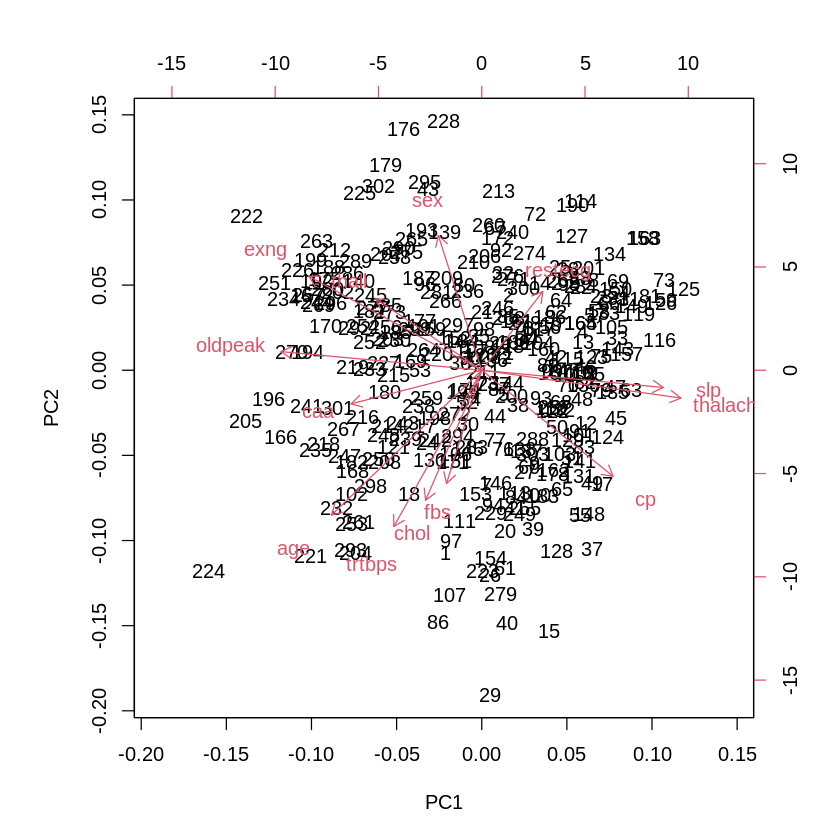

In [ ]:
pca<-prcomp(data,scale=T)
biplot(pca)

In [ ]:
posicion_promedio_columnas <- function(data, ...) {
  # Combinar las listas de posiciones en un dataframe
  listas <- list(...)
  df <- do.call(cbind, listas)

  # Obtener los nombres de las columnas desde el dataframe 'data'
  nombres_columnas <- colnames(data)

  # Inicializar un vector para almacenar los promedios
  promedios <- numeric(ncol(data))

  # Calcular el promedio de la posición de cada columna
  for (i in 1:ncol(data)) {
    posiciones <- which(df == i, arr.ind = TRUE)[, 1]  # Obtener las posiciones de la columna 'i'
    promedios[i] <- mean(posiciones)
  }

  # Crear un dataframe con el nombre de la columna y su posición promedio
  resultado <- data.frame(nombre_columna = nombres_columnas, promedio = promedios)

  # Ordenar por la posición promedio
  resultado <- resultado[order(resultado$promedio), ]

  return(resultado)
}

In [ ]:
rf_est_fw <- forward.ranking(data,class,method="rf.est")
lda_est_fw <- forward.ranking(data,class,method="lda.est")
svm_est_fw <- forward.ranking(data,class,method="svm.est")
rf_est_bw <- greedyBackward(data,class,method="rf.est")
lda_est_bw <- greedyBackward(data,class,method="lda.est")
svm_est_bw <- greedyBackward(data,class,method="svm.est")
kruskal_wallis <- kruskalWallis(data,class)
imp_rf_rfe <- rfe(data,class,method="imp.rf")
imp_svm_rfe <- rfe(data,class,method="imp.linsvm")

cat("Greedy Forward rf.est: ", rf_est_fw)
cat("\nGreedy Forward lda.est: ", lda_est_fw)
cat("\nGreedy Forward svm.est: ", svm_est_fw)
cat("\nGreedy Backward rf.est: ", rf_est_bw)
cat("\nGreedy Backward lda.est: ", lda_est_bw)
cat("\nGreedy Backward svm.est: ", greedyBackward(data,class,method="svm.est"))
cat("\nKruskal Wallis: ", kruskal_wallis)
cat("\nRFE imp.rf: ", imp_rf_rfe)
cat("\nRFE imp.linsvm: ", imp_svm_rfe)

Greedy Forward rf.est:  13 8 12 3 11 2 9 7 1 4 6 5 10
Greedy Forward lda.est:  3 4 12 13 8 2 11 6 7 10 1 5 9
Greedy Forward svm.est:  13 10 3 8 12 9 6 1 2 7 4 5 11
Greedy Backward rf.est:  13 12 3 11 9 7 6 2 1 4 5 8 10
Greedy Backward lda.est:  3 10 2 12 13 8 11 5 6 7 1 4 9
Greedy Backward svm.est:  12 3 8 9 2 10 13 4 6 11 5 7 1
Kruskal Wallis:  3 12 9 8 10 13 11 2 1 7 4 5 6
RFE imp.rf:  3 13 12 10 11 2 8 1 9 6 4 7 5
RFE imp.linsvm:  10 3 12 13 8 2 9 4 11 7 5 6 1

In [ ]:
resultado <- posicion_promedio_columnas(data, rf_est_fw, lda_est_fw, svm_est_fw, rf_est_bw, lda_est_bw, svm_est_bw, kruskal_wallis, imp_rf_rfe, imp_svm_rfe)

print(resultado)

   nombre_columna  promedio
3              cp  2.000000
12            caa  2.888889
13          thall  3.222222
8        thalachh  5.666667
2             sex  6.222222
11            slp  6.666667
10        oldpeak  6.888889
9            exng  8.444444
4          trtbps  9.111111
7         restecg  9.444444
1             age  9.555556
6             fbs  9.555556
5            chol 11.333333


A partir del biplot, podemos ver que hay tres grupos de variables que parecen relacionarse:
* Age, trtbps, chol y fbs: Estos serían edad, presión sanguínea en reposo, colesterol y nivel de azúcar en sangre en ayuno.
* Talachh y slp: Máximo ritmo cardíaco alcanzado en el entrenamiento e inclinación del segmento ST del electrocardiograma (que muestra la repolarización de los ventrículos).
* Exng y thall: Dolores de pecho durante el ejercicio y examen para evaluar la gravedad de las obstrucciones en las arterias coronarias.

A pesar del poco conocimiento que tengo sobre el tema, estas agrupaciones no parecen erradas. Por ejemplo, al observar la primera, se puede pensar que la edad de una persona está relacionada con el nivel de colesterol que puede tener y con la presión sanguínea en reposo (supongo que también estaría relacionada durante el ejercicio).

Algo interesante que también se destaca es que, según el biplot, al estar tan relacionadas estas variables, se puede ver en el promedio de los rankings que aquí también se encuentran juntas. Por ejemplo, age, trtbps, chol y fbs se ubican en las peores posiciones del ranking, y lo mismo sucede con slp y talachh, que se sitúan en promedio en la quinta y sexta posición.

Sé que es raro presentar el promedio de los métodos, pero al evaluarlos, pude ver que en su mayoría muestran rankings relativamente parecidos, así que utilicé este promedio para intentar obtener un ranking definitivo.

Igualmente, basándome en la experiencia, debería centrarme en los resultados de Kruskal-Wallis y RFE para evaluar cuáles son las variables más importantes.